In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd ..

/content/gdrive


In [ ]:
os.chdir('gdrive/My Drive/Classroom/Workshop on SPAD Mixed/Visual_Odometry/')

In [ ]:
pwd

'/content/gdrive/.shortcut-targets-by-id/1C15wQ_2vs6_ZEjTE8bnk4afkWvB8_t77/Visual_Odometry'

In [ ]:
!ls

 00.txt     'data old'	 image_1   readme.txt
 calib.txt   image_0	 map.png   times.txt


In [ ]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())
import cv2

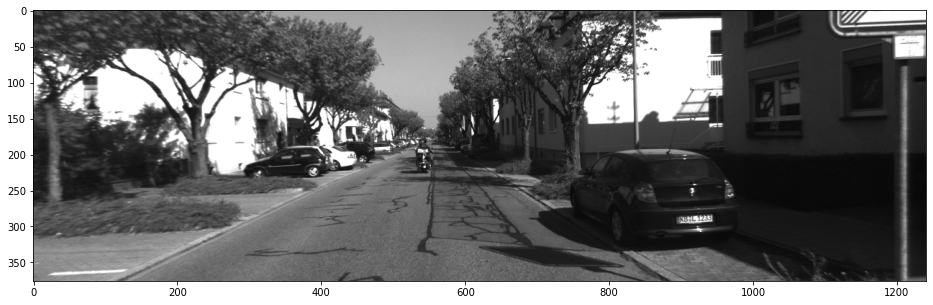

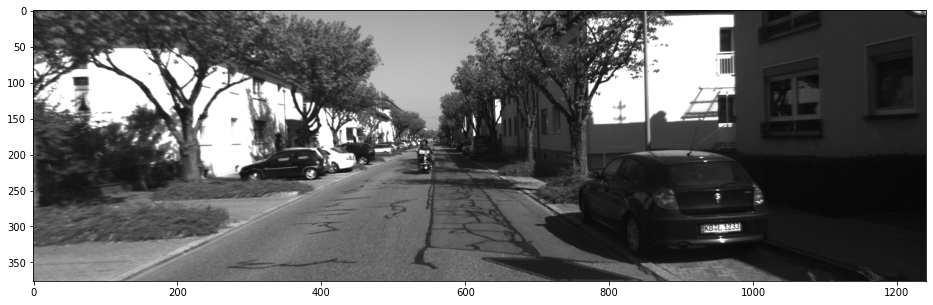

In [ ]:
img_1 = cv2.imread('image_0/000000.png')
img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
plt.figure(figsize=[16,5])
plt.imshow(img_1)
plt.show()
img_2 = cv2.imread('image_0/000001.png')
img_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2RGB)
plt.figure(figsize=[16,5])
plt.imshow(img_2)

In [ ]:
feature_extractor = cv2.SIFT_create()
# detect the key points
kp_1, desc_1 = feature_extractor.detectAndCompute(img_1, None)
kp_2, desc_2 = feature_extractor.detectAndCompute(img_2, None)

In [ ]:
print(len(kp_1))
print(len(kp_2))
print(kp_1[0].pt)
print(kp_2[0].pt)

3206
3226
(3.266590118408203, 121.02787780761719)
(2.404348850250244, 85.66073608398438)


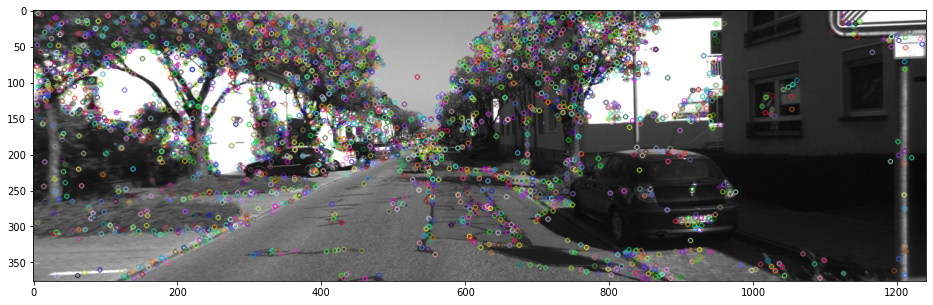

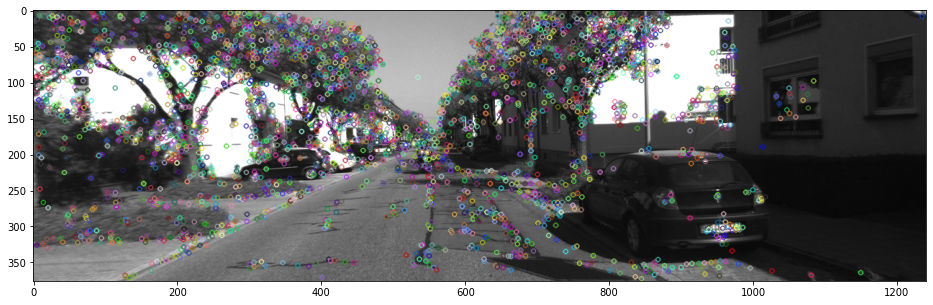

In [ ]:
disp_1 = cv2.drawKeypoints(img_1, kp_1, img_1)
plt.figure(figsize=[16,5])
plt.imshow(disp_1)
plt.show()
disp_2 = cv2.drawKeypoints(img_2, kp_2, img_2)
plt.figure(figsize=[16,5])
plt.imshow(disp_2)

In [ ]:
lk_params = dict(winSize  = (21, 21), 
				#maxLevel = 3,
             	criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

def featureTracking(image_ref, image_cur, px_ref):
	kp2, st, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params)  #shape: [k,2] [k,1] [k,1]
#cv2.calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts[, winSize[, maxLevel[, criteria]]])
	st = st.reshape(st.shape[0]) # to make it into a true python 1D array e.g. (3574,)
	kp1 = px_ref[st == 1]
	kp2 = kp2[st == 1]

	return kp1, kp2

In [ ]:
#kp_array = np.array([x.pt for x in kp_1])

# Intrinsics

P0:[7.188560000000e+02 0.000000000000e+00 6.071928000000e+02 0.000000000000e+00 
    0.000000000000e+00 7.188560000000e+02 1.852157000000e+02 0.000000000000e+00 
    0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00]

#Extrinsics
1.000000e+00 9.043680e-12 2.326809e-11 5.551115e-17 
9.043683e-12 1.000000e+00 2.392370e-10 3.330669e-16 
2.326810e-11 2.392370e-10 9.999999e-01 -4.440892e-16

9.999978e-01 5.272628e-04 -2.066935e-03 -4.690294e-02 
-5.296506e-04 9.999992e-01 -1.154865e-03 -2.839928e-02 
2.066324e-03 1.155958e-03 9.999971e-01 8.586941e-01

#9.999978e-01 5.272628e-04 -2.066935e-03 -4.690294e-02 -5.296506e-04 9.999992e-01 -1.154865e-03 -2.839928e-02 2.066324e-03 1.155958e-03 9.999971e-01 8.586941e-01
# A 3x4 matrix with Rotation and translation
#9.999978e-01 5.272628e-04 -2.066935e-03 -4.690294e-02 
#-5.296506e-04 9.999992e-01 -1.154865e-03 -2.839928e-02 
#2.066324e-03 1.155958e-03 9.999971e-01 8.586941e-01

In [ ]:
class PinholeCamera:
	def __init__(self, width, height, fx, fy, cx, cy, 
				k1=0.0, k2=0.0, p1=0.0, p2=0.0, k3=0.0):
		self.width = width
		self.height = height
		self.fx = fx
		self.fy = fy
		self.cx = cx
		self.cy = cy
		#self.distortion = (abs(k1) > 0.0000001)
		self.d = [k1, k2, p1, p2, k3]

In [ ]:
STAGE_FIRST_FRAME = 0
STAGE_SECOND_FRAME = 1
STAGE_DEFAULT_FRAME = 2
minimum_feature_points = 2000

**FINDESSENTIAL MATRIX HELP**

   @param prob Parameter used for the RANSAC or LMedS methods only. It specifies a desirable level of confidence (probability) that the estimated matrix is correct.

.   @param threshold Parameter used for RANSAC. It is the maximum distance from a point to an epipolar line in pixels, beyond which the point is considered an outlier and is not used for computing the final fundamental matrix. It can be set to something like 1-3, depending on the accuracy of the point localization, image resolution, and the image noise.

.   @param mask Output array of N elements, every element of which is set to 0 for outliers and to 1 for the other points. The array is computed only in the RANSAC and LMedS methods.

In [ ]:
class VisualOdometry:
  def __init__(self, cam, annotations): # cam --> odj rep the camera, annotations --> 00.txt
    self.frame_stage = 0 # current frame ID
    self.cam = cam # intrinsics
    self.new_frame = None # current frame
    self.last_frame = None #previous frame
    self.cur_R = None # Rotations matrix between prev and curr frame
    self.cur_t = None # Transalation Vector between prev and curr frame
    self.px_ref = None # The keypoints in the prev frame
    self.px_cur = None # The keypoints in the current frame
    self.focal = cam.fx # focal length
    self.pp = (cam.cx, cam.cy) # image center
    self.trueX, self.trueY, self.trueZ = 0, 0, 0 # Ground truth
    self.detector = cv2.SIFT_create() # SIFT keypoint detector
    with open(annotations) as f:
      self.annotations = f.readlines()

  def getAbsoluteScale(self, frame_id):
    ss = self.annotations[frame_id-1].strip().split()
    
    x_prev = float(ss[3])
    y_prev = float(ss[7])
    z_prev = float(ss[11])

    ss = self.annotations[frame_id].strip().split()
    
    x = float(ss[3])
    y = float(ss[7])
    z = float(ss[11])

    self.trueX, self.trueY, self.trueZ = x,y,z
    return np.sqrt((x-x_prev)**2+(y-y_prev)**2+(z-z_prev)**2)

  def processFirstFrame(self):
    self.px_ref,_ = self.detector.detectAndCompute(self.new_frame,None)
    self.px_ref = np.array([x.pt for x in self.px_ref], dtype=np.float32)
    self.frame_stage = STAGE_SECOND_FRAME

  def processSecondFrame(self):
    self.px_ref, self.px_cur = featureTracking(self.last_frame, self.new_frame, self.px_ref)
    E, mask = cv2.findEssentialMat(self.px_ref, self.px_cur, focal=self.focal, pp=self.pp, method = cv2.RANSAC, prob =0.999, threshold = 1)
    _,  self.cur_R, self.cur_t, _ = cv2.recoverPose(E, self.px_ref, self.px_cur, focal=self.focal, pp=self.pp)
    self.frame_stage = STAGE_DEFAULT_FRAME
    self.px_ref = self.px_cur  

  def processFrame(self,frame_id):
    self.px_ref, self.px_cur = featureTracking(self.last_frame, self.new_frame, self.px_ref)
    E, mask = cv2.findEssentialMat(self.px_ref, self.px_cur, focal=self.focal, pp=self.pp, method = cv2.RANSAC, prob =0.999, threshold = 1)
# Essential matrix is always known upto a scale factor
    _,  R, t, _ = cv2.recoverPose(E, self.px_ref, self.px_cur, focal=self.focal, pp=self.pp)
    absolute_scale = self.getAbsoluteScale(frame_id)
    self.cur_R = R.dot(self.cur_R)
    self.cur_t = self.cur_t + absolute_scale*self.cur_R.dot(t)
    if (self.px_ref.shape[0]) < minimum_feature_points: # to have a robust estimate of Essential matrix
      self.px_cur,_ = self.detector.detectAndCompute(self.new_frame,None)
      self.px_cur = np.array([x.pt for x in self.px_cur], dtype=np.float32)
    self.px_ref = self.px_cur

  def update(self, img, frame_id):
    self.new_frame = img
    if(self.frame_stage == STAGE_FIRST_FRAME):
      self.processFirstFrame()
    elif(self.frame_stage == STAGE_SECOND_FRAME):
      self.processSecondFrame()
    elif(self.frame_stage == STAGE_DEFAULT_FRAME):
      self.processFrame(frame_id)
    self.last_frame = self.new_frame



In [ ]:
cam = PinholeCamera(1241.0,376.0,7.188560000000e+02, 7.188560000000e+02, 6.071928000000e+02, 1.852157000000e+02)
vo = VisualOdometry(cam, '00.txt')

traj = np.zeros((600,600,3),dtype = np.uint8)

for img_id in range(4541):
  img = cv2.imread('image_0/'+str(img_id).zfill(6)+'.png')
  vo.update(img, img_id)

  est_transl = vo.cur_t
  if (img_id>2):
    vo_est_x,vo_est_y,vo_est_z = est_transl[0],est_transl[1],est_transl[2]
  else:
    vo_est_x,vo_est_y,vo_est_z = 0,0,0  


  draw_x, draw_y = int(vo_est_x)+300, int(vo_est_z)+200 # Horizontal axis is X-axis, vertical axis is z-axis as per the

  cv2.circle(traj, (draw_x, draw_y),1,(255,0,0),1)

  cv2.rectangle(traj, (10,10),(600,60),(0,0,0),-1)
  text = "Coordinaates_gnd_truth: x=%2fm, y=%2fm, z=%2fm"%(vo_est_x,vo_est_y,vo_est_z)
  cv2.putText(traj, text, (20,40), cv2.FONT_HERSHEY_PLAIN,1,(255,255,255),1)
    # Horizontal direction x, vertical direction will be the z-axis

  #cv2_imshow(img)
  #cv2_imshow(traj)

  plt.imshow(img)
  plt.show()
  plt.figure(figsize=(10, 10))
  plt.imshow(traj)
  plt.show()
  clear_output(wait=True)


In [ ]:
import numpy as np
x_prev = 4.962461e+00
y_prev = -3.311658e+00
z_prev = 8.958341e+01

x = 5.460049e+00
y = -3.327578e+00
z = 8.960332e+01
print(np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev)))

(376, 1241, 3)